# Derived from https://tensorflow.keras.io/examples/imdb_cnn/

In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


# Set Keras backend

In [2]:
import os
os.environ["KERAS_BACKEND"] =  "tensorflow" # torch

import keras

print(f"Keras version {keras.__version__}, backend: {keras.backend.backend()}")

if keras.backend.backend() ==  "tensorflow":
  import tensorflow as tf
  print(f"TensorFlow version {tf.__version__}")
elif keras.backend.backend() ==  "torch":
  import torch
  print(f"PyTorch version {torch.__version__}")



Keras version 3.8.0, backend: tensorflow
TensorFlow version 2.18.0


# List GPUs available

In [3]:
# prompt: depending on backend, list gpu devices available

if keras.backend.backend() == "tensorflow":
  gpu_available = tf.config.list_physical_devices('GPU')
  if gpu_available:
    print("GPU available with TensorFlow:")
    for gpu in gpu_available:
      print(f"  {gpu}")
  else:
    print("No GPU available with TensorFlow.")
elif keras.backend.backend() == "torch":
  if torch.cuda.is_available():
    print("GPU available with PyTorch:")
    device_names = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
    print(f"GPUs: {', '.join(device_names)}")
  else:
    print("No GPU available with PyTorch.")
else:
    print("Unknown Keras backend.")

GPU available with TensorFlow:
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Standard imports

In [4]:
import keras

import numpy as np
import os

import matplotlib.pyplot as plt
import IPython


from keras.utils import plot_model

import pdb

from pprint import pprint


# Keras imports

In [5]:
from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv1D, Conv2D, MaxPooling2D, Embedding, GlobalMaxPooling1D


from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils import plot_model

# Parameters:
- max_features: number of words in the vocabulary (and hence, the length of the One Hot Encoding feature vector)
- maxlen: number of words in a review
- embedding_dims: length of word vector
- filters: number of convolutional kernels.  These are "features" created by convolution.

In [6]:
# set parameters:
max_features = 20000
maxlen = 200
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 8

special = { "<PAD>": 0,
           "<START>": 1,
           "<UNK>": 2
           }

In [7]:
print('Loading data...')
# start_char == 1: start of sequence character is encoded with integer 1
# oov_char   == 2: Out of Vocabulary word is encoded with integer 2
# index_from == 3: The first word (i.e, most frequent) in the vocabulary is encoded with integer 3
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features,
                                                        start_char=special["<START>"],
                                                        oov_char=special["<UNK>"],
                                                        index_from=3
                                                        )
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test =  keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)



Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
X_train shape: (25000, 200)
X_test shape: (25000, 200)


# Examine the text data

In [8]:

# See https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset
# word_index: maps words to rank in vocabulary (0 is most frequent)
word_index = keras.datasets.imdb.get_word_index()

# Create word to index map
# load_data has assigned indexes 0, 1, 2 to (<PAD>, <START>, <UNK>) so load_data assigns the rank 0 word to index 3
word_index = { w:(k+3) for w,k in word_index.items() }

# Add the special characters to the word to index map
for word, idx in special.items():
  word_index[word] = idx

# Reverse map: index to word
# Index_word: map index to word
index_word = { idx:w for (w, idx) in word_index.items() }

sentiment = { 0: "negative", 1: "positive"}

# Print row header
print("i\tSentiment\treview")
print("-\t---------\t------")

# Examine the first few training examples
# An example is a sequence (of length exactly maxline (because we have added padding)
# - Sequence of integers
# - Where integer i represents word index_word[i]
for i, rev in enumerate(X_train[0:5]):
  # Map each index in the example back to word
  rev_words = [ index_word[idx] for idx in rev if idx != 0]

  # Sentiment sent is the target value
  sent = y_train[i]
  print("{i:d}:\t({sent:s})\t{r:s}".format(i=i, sent=sentiment[y_train[i]], r= " ".join(rev_words)) )

i	Sentiment	review
-	---------	------
0:	(positive)	and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lo

In [9]:
X_train.shape

(25000, 200)

# Utility functions

In [10]:

def plotModel(model, modelName):
  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)

  return plotFile

def plot_training(history):
  """
  Plot training and validation statistics
  - accuracy vs epoch number
  - loss     vs epoch number

  From https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
  """

  # Accuracy
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  # Loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [11]:
def createModel(input_shape=(maxlen,), doConv=True, learn_embeddings=True):
  """
  Create a Sequential model

  Parameters
  -----------
  doConv: Boolean.  If True, create features using Convolutional Layer
  learn_embeddings: Boolean.  If True, learn embeddings; else just use OHE as embedding

  Returns
  --------
  model: Sequential model

  - First layer is an Embedding Layer
  -  if learn_embedding is True: the model will "learn" the best embedding
  -  if learn_embedding is False: the embedding will just be the OHE
  """
  model = Sequential()

  # we start off with an efficient embedding layer which maps
  # our vocab indices into embedding_dims dimensions
  if learn_embeddings:
    # Word embeddings are trainable and small size (embedding_dims) vectors
    # Embedding layer maps
    # - elements of sequence (OHE vectors of length max_features)
    # - to a vector of length embedding_dims
    # - where maxlen is the maximum length of a sequence
    model.add(Embedding(max_features,
                       embedding_dims,
                        )
    )
  else:
    # "Embeddings" are simply One Hot Encoding of the vocabulary
    # - word embeddings are NOT trainable and LARGE size (length of vocabulary) vectors
    # NOTE: this is NOT the best way to perform OHE ! Super slow !
    #   We do this just to show that OHE is a simple type of embedding
    weights_OHE= createOHE()
    embedding_dims_OHE = weights_OHE.shape[-1]

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                      embedding_dims_OHE,
                      weights=[weights_OHE],
                      trainable=False
                     )
         )

  model.add(Dropout(0.2))

  if doConv:
    # we add a Convolution1D, which will learn features from "kernel_size" consecutive tokens
    model.add(Conv1D(filters,
                    kernel_size,
                    padding='valid',
                    activation='relu',
                    strides=1))

  # we use Global Max Pooling to eliminate the time dimensions
  # - Turns variable length sequence to fixed length
  model.add(GlobalMaxPooling1D())

  # We add a vanilla hidden layer to create new features from the fixed length encoding
  model.add(Dense(hidden_dims))
  model.add(Dropout(0.2))
  model.add(Activation('relu'))

  # Add Binary Classifier as final layer
  # We project onto a single unit output layer, and squash it with a sigmoid:
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  return model

def trainModel(model):
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc']
                )

  es_callback = EarlyStopping(monitor='val_loss', min_delta=.005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

  callbacks = [ es_callback,
                # ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
                ]

  history = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=callbacks)

  return history

def createOHE():
  mat = np.diag( np.ones(max_features))
  return mat

# Simple model
- Pseudo Embedding: converts interger index into OHE of length max_features
- GlobalMaxPooling1D to convert from variable length to fixed length

Summary
- Input: Sequence (length maxlen) of words represented as integer
- Converted to sequence (length maxlen)of OHE vectors (each of length max_features)
- Pooled over sequence length dimension to give fixed length vector (length max_features)
- FC layer + Binary Classifier

Notes
- The number of parameters in the "embedding layer" (really OHE)
- Is mapping of Vocab size (max_features=5000) tokens to OHE vector of length Vocab size(max_features=5000(
  - BIG !



In [12]:
model_ohe = createModel(input_shape=(maxlen, ), learn_embeddings=False, doConv=False)



In [13]:
history_ohe = trainModel(model_ohe)

Epoch 1/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - acc: 0.8137 - loss: 0.4038 - val_acc: 0.8719 - val_loss: 0.3022
Epoch 2/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - acc: 0.9227 - loss: 0.1908 - val_acc: 0.8667 - val_loss: 0.3215
Epoch 3/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - acc: 0.9546 - loss: 0.1176 - val_acc: 0.8622 - val_loss: 0.3518


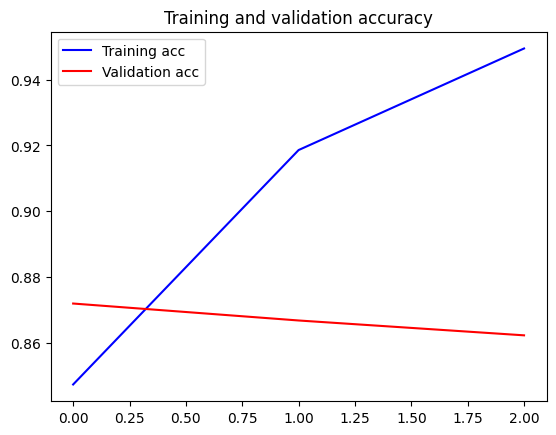

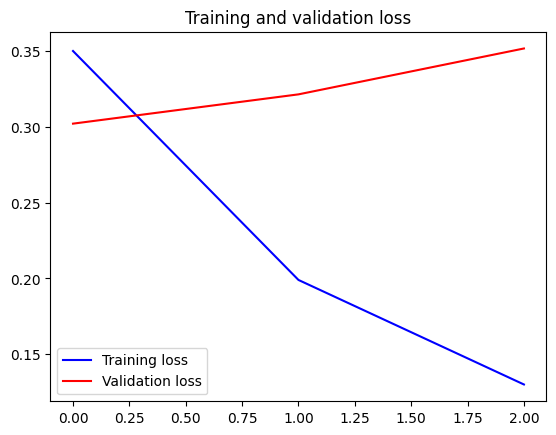

In [14]:
plot_training(history_ohe)

## Note: the test data set was used as the validation_data in the fit method above
- so nothing really to see here


In [15]:
score, acc = model_ohe.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - acc: 0.8700 - loss: 0.3039
Test score: 0.3021557033061981
Test accuracy: 0.8718799948692322


In [16]:
print("OHE Embeddings (first few):")
embeddings_ohe = model_ohe.layers[0].get_weights()[0]
embeddings_ohe[:4,:7]

OHE Embeddings (first few):


array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

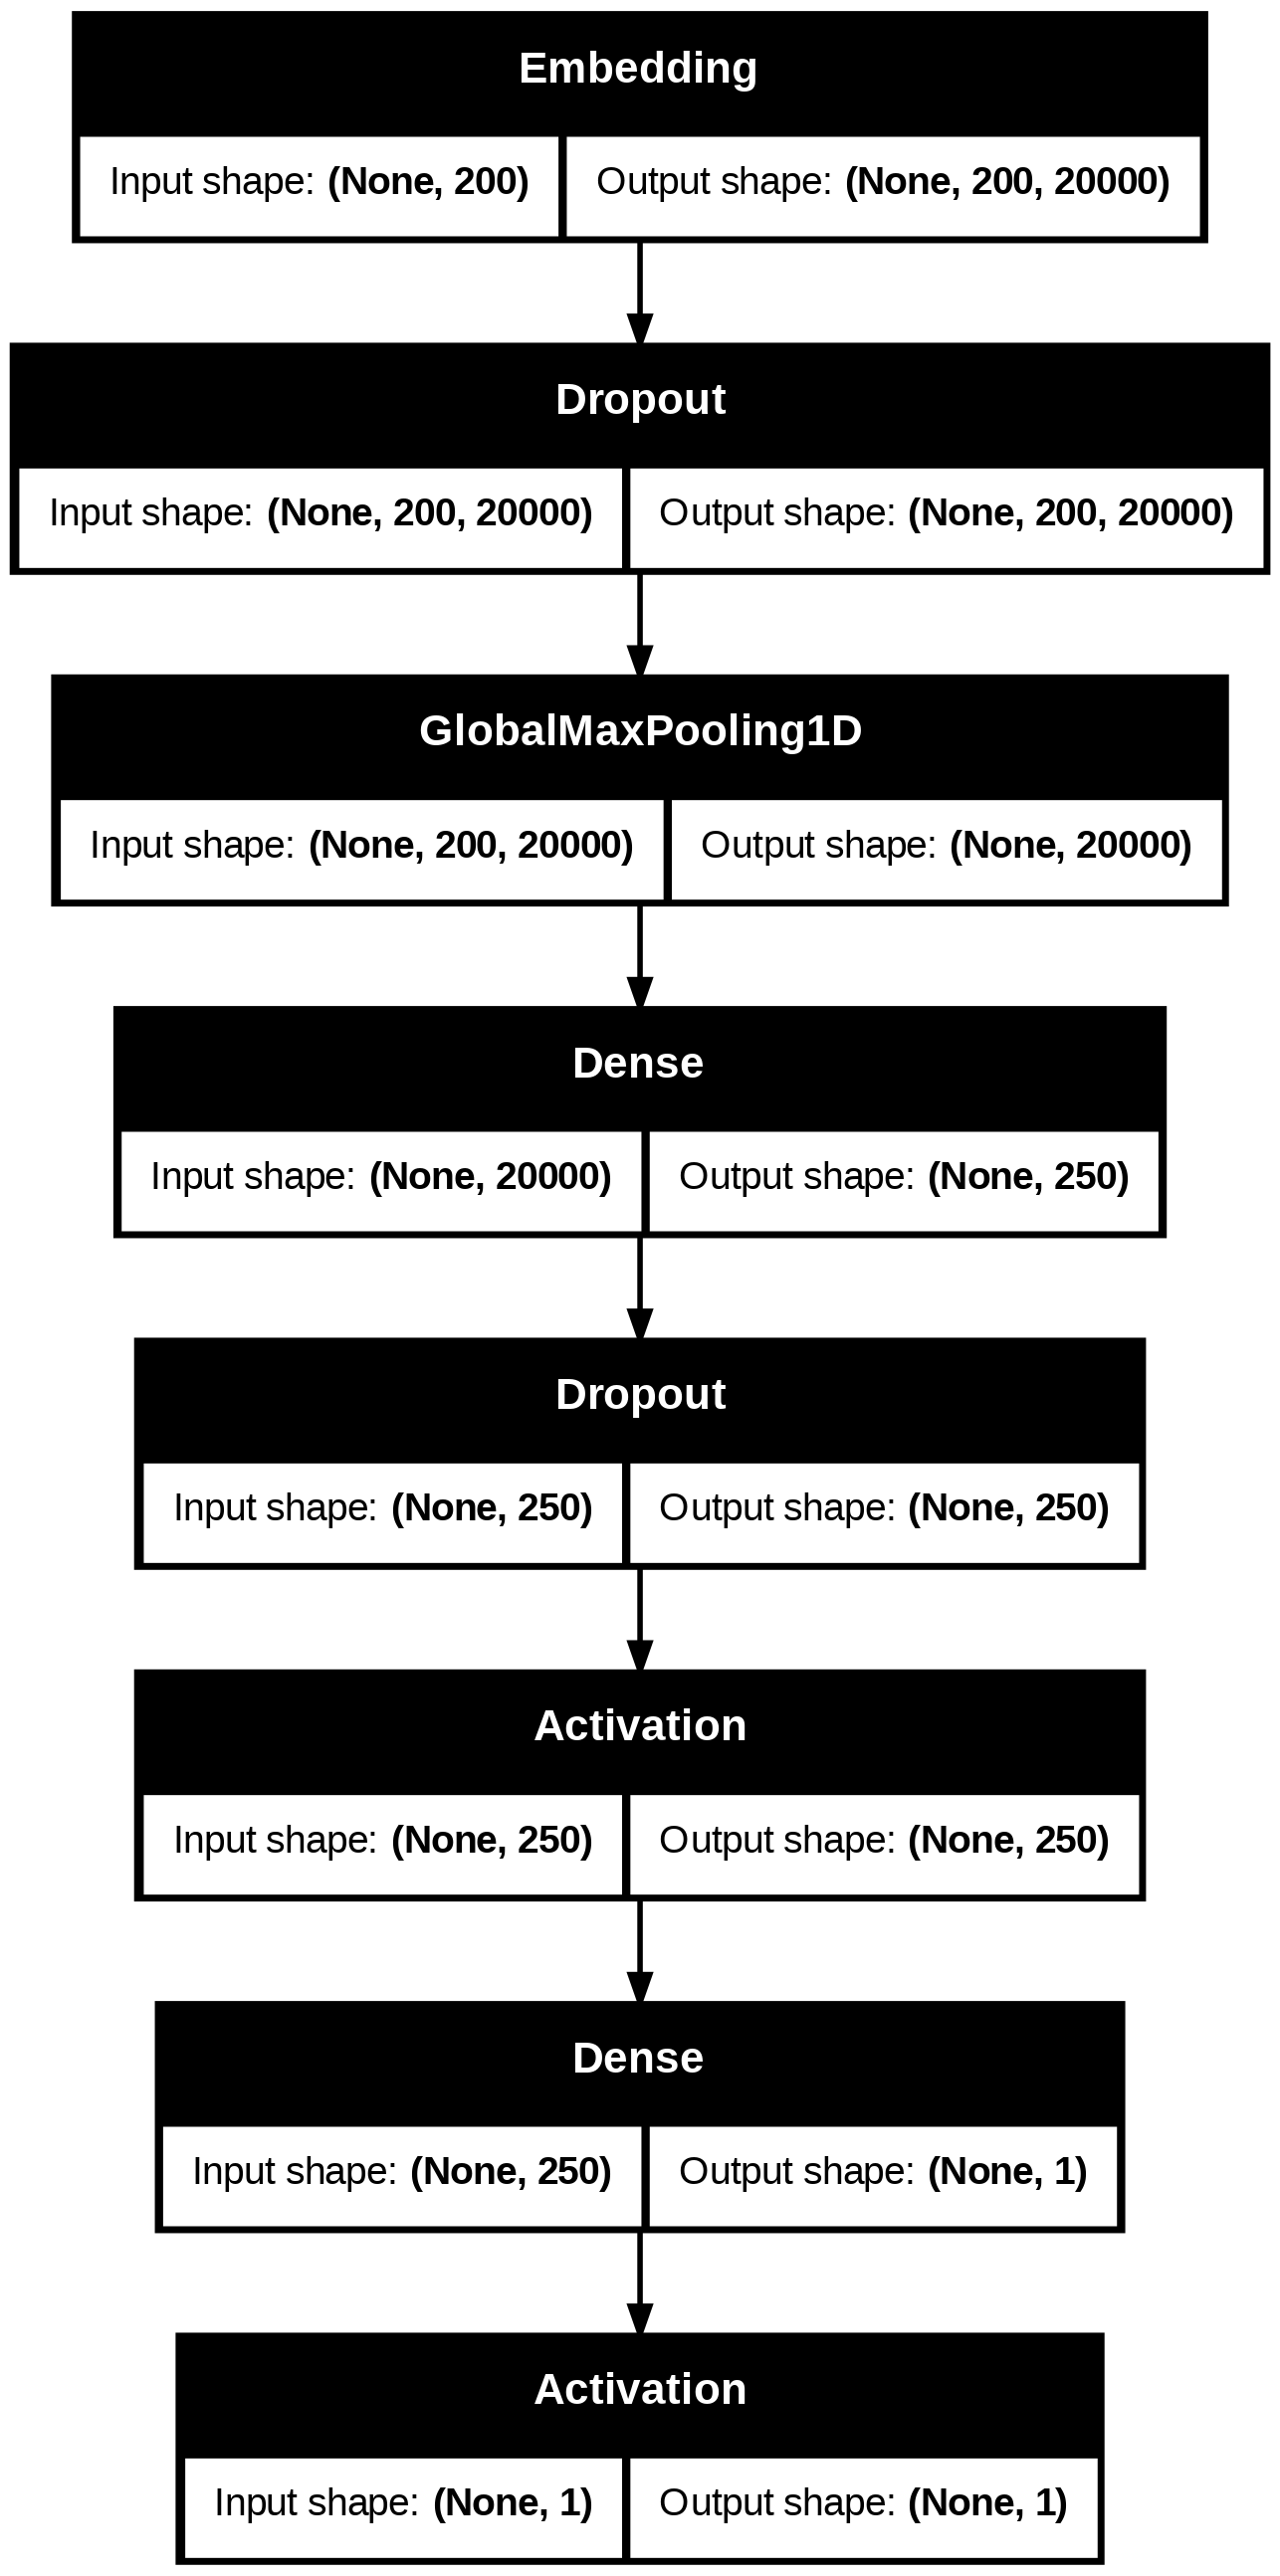

In [17]:
plot_model(model_ohe,  show_shapes=True)

# Model with learned embeddings
- learn low-dimensional word embeddings

Summary
- same as "simple" model, but use word vectors rather than OHE

Notes
- The number of parameters in the embedding layer (learned embedding)
- Is mapping of Vocab size (max_features=5000) tokens to  vector of length embedding_dims=50 (versus Vocab size(max_features=5000 for OHE)
  - Smaller by factor of 100 !
- The Dense layer that follows also has fewer parameters
  - Factor of 100 (plus biases) because inputs are smaller by a factor of 100





In [18]:
model_emb = createModel(input_shape=(maxlen,), doConv=False)


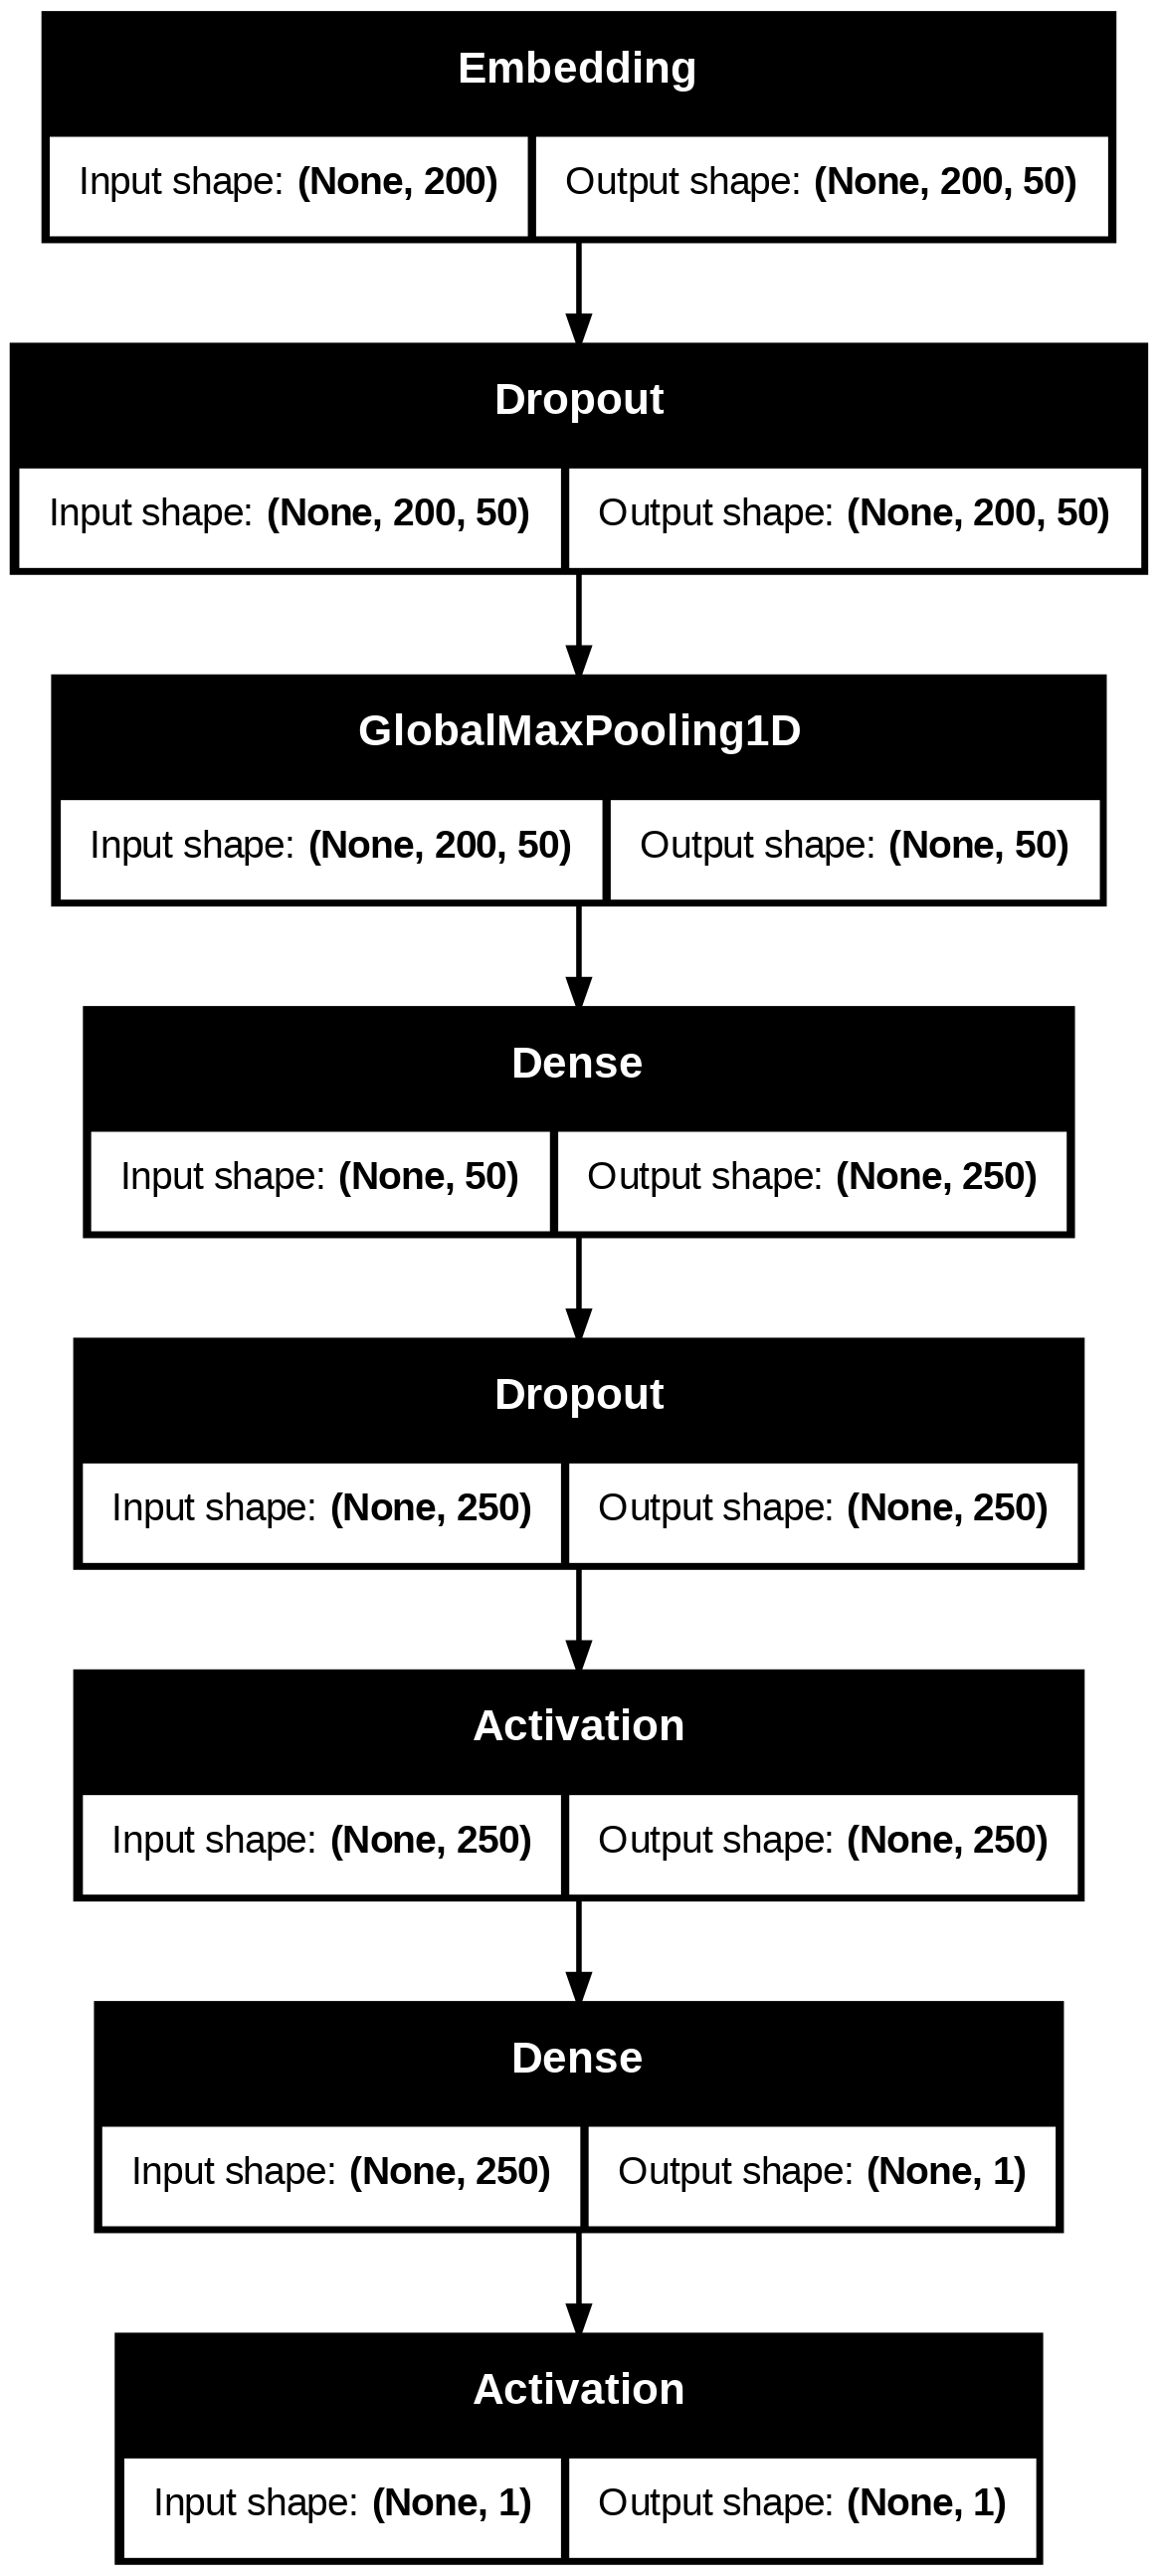

In [19]:
model_emb.build(input_shape=(None, maxlen))

plotFile = plotModel(model_emb, "imbdb_emb")
IPython.display.Image(plotFile)

In [20]:
history_emb=trainModel(model_emb)

Epoch 1/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - acc: 0.6952 - loss: 0.5453 - val_acc: 0.8600 - val_loss: 0.3288
Epoch 2/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.8916 - loss: 0.2649 - val_acc: 0.8591 - val_loss: 0.3246
Epoch 3/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.9243 - loss: 0.1936 - val_acc: 0.8618 - val_loss: 0.3208
Epoch 4/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9450 - loss: 0.1444 - val_acc: 0.8548 - val_loss: 0.3407
Epoch 5/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - acc: 0.9618 - loss: 0.1060 - val_acc: 0.8422 - val_loss: 0.3938


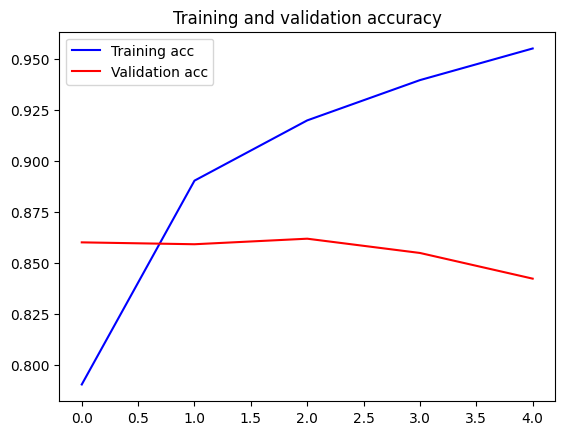

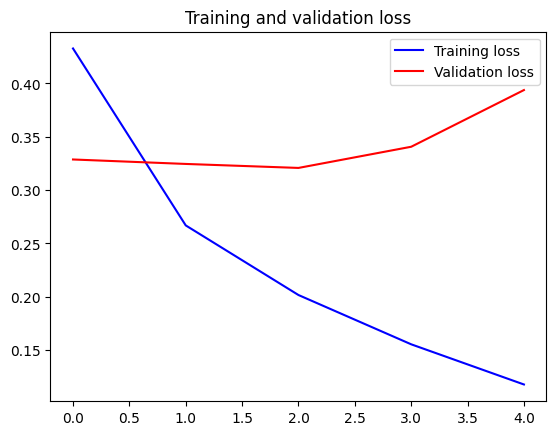

In [21]:
plot_training(history_emb)

In [22]:
score, acc = model_emb.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.8619 - loss: 0.3198
Test score: 0.32083672285079956
Test accuracy: 0.8618000149726868


# Model with learned embeddings, n-grams (phrases)
- conv1d to learn n-grams

Summary
- After converting words to word vectors: use multiple kernels to find 3-grams


In [23]:
model_emb_ngram = createModel(doConv=True)


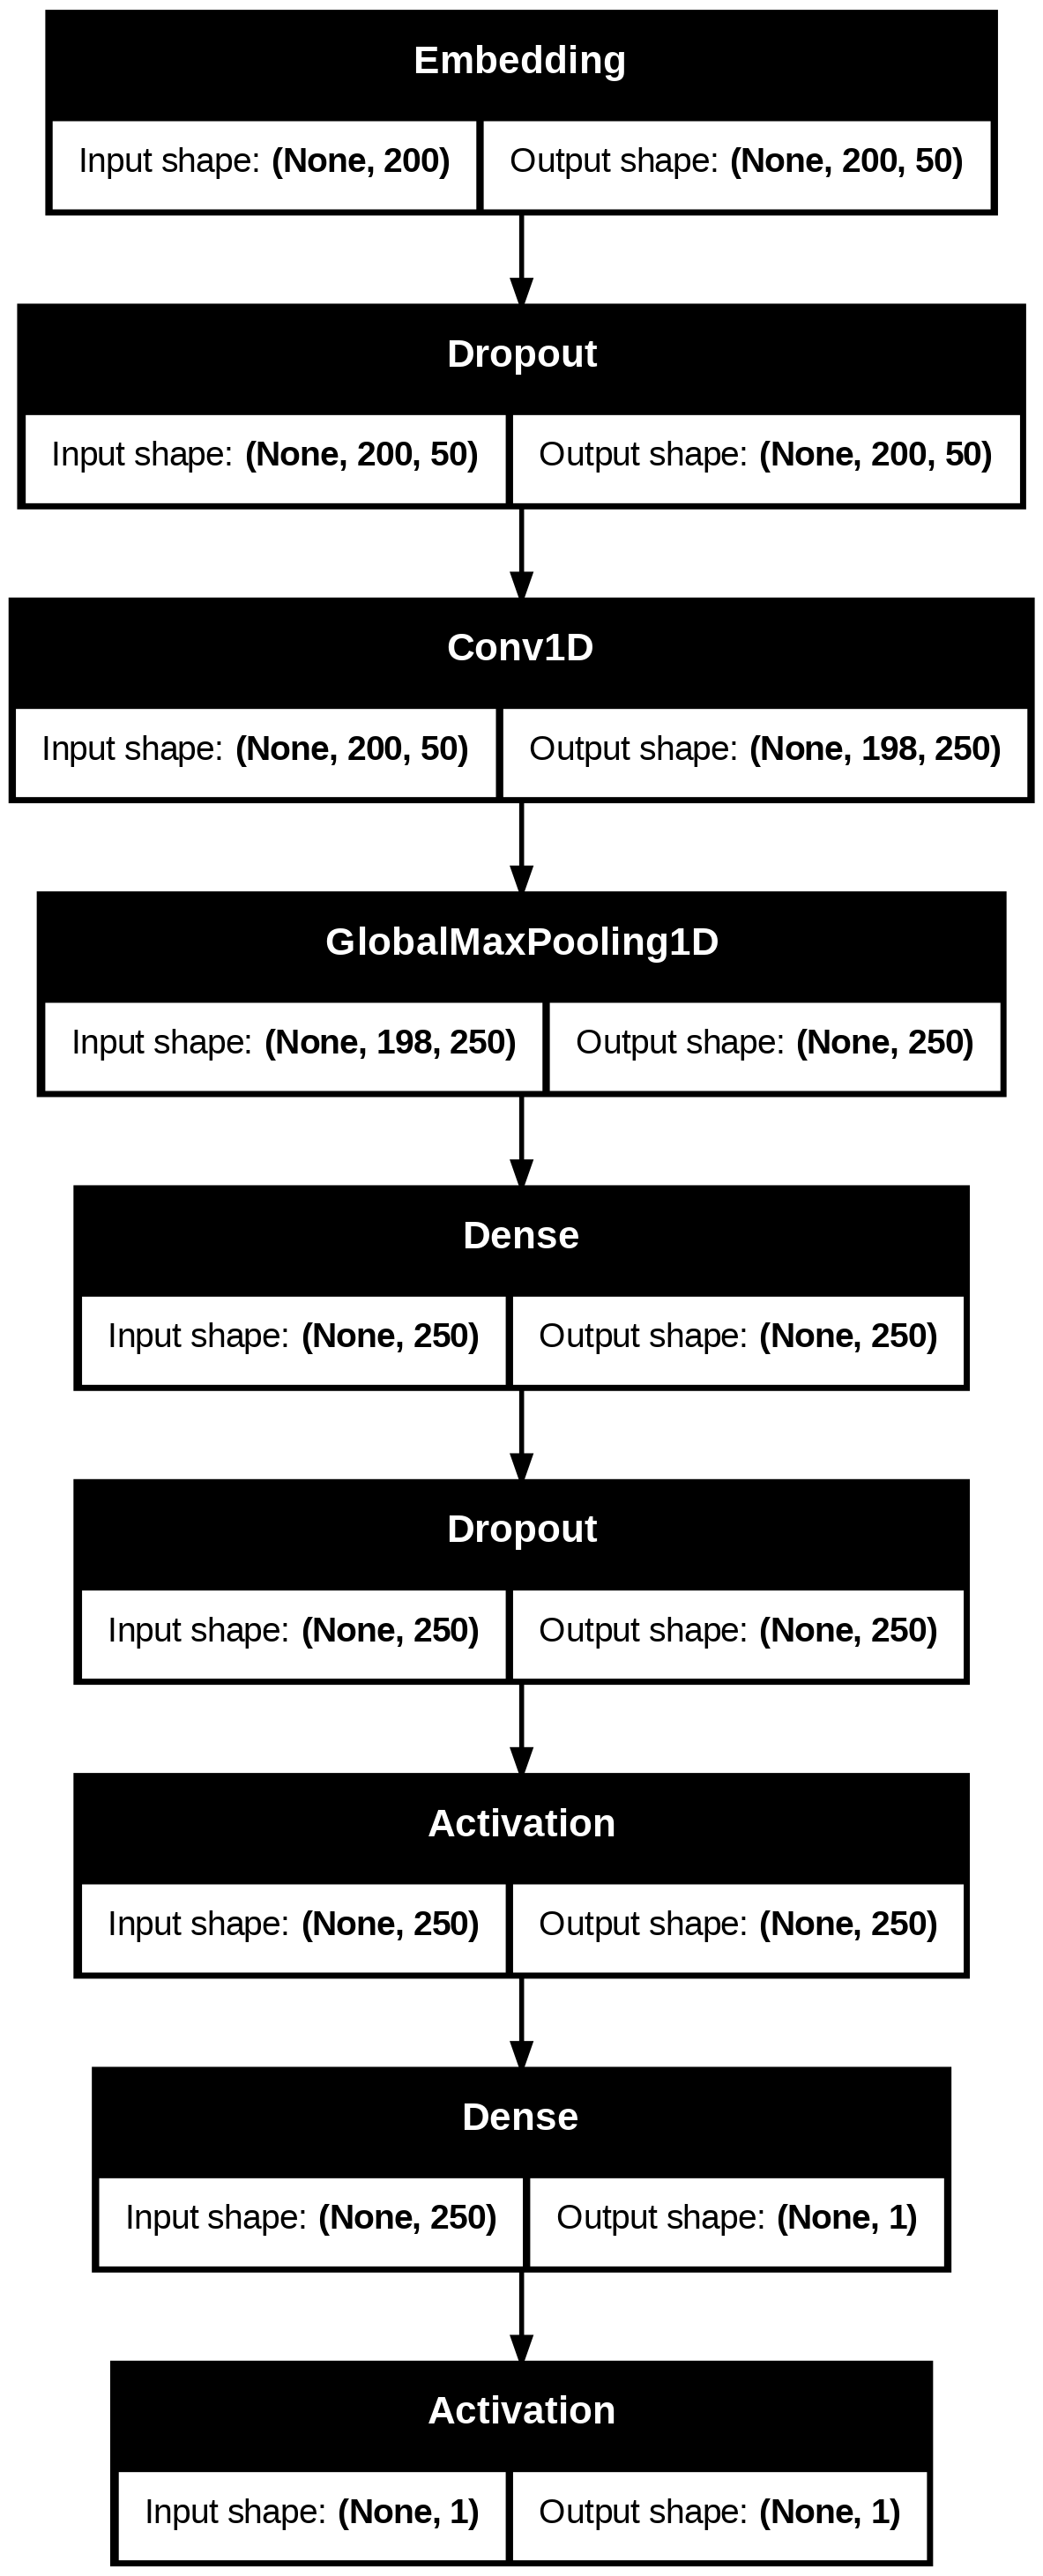

In [24]:
model_emb_ngram.build(input_shape=(None, maxlen,))

plotFile = plotModel(model_emb_ngram, "imbdb_emb_ngram")
IPython.display.Image(plotFile)

In [25]:
history_emb_ngram=trainModel(model_emb_ngram)

Epoch 1/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - acc: 0.7086 - loss: 0.5221 - val_acc: 0.8792 - val_loss: 0.2854
Epoch 2/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - acc: 0.9128 - loss: 0.2222 - val_acc: 0.8567 - val_loss: 0.3376
Epoch 3/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - acc: 0.9598 - loss: 0.1151 - val_acc: 0.8774 - val_loss: 0.3198


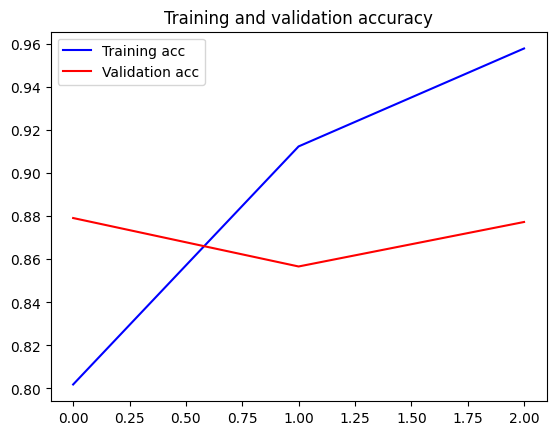

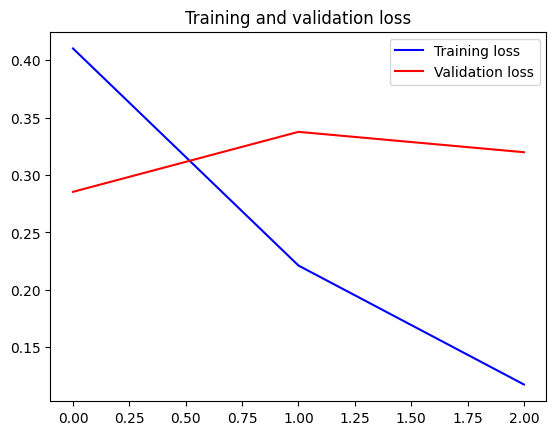

In [26]:
plot_training(history_emb_ngram)

In [27]:
score, acc = model_emb_ngram.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - acc: 0.8814 - loss: 0.2829
Test score: 0.28536438941955566
Test accuracy: 0.8791999816894531


# Try an LSTM as a means of obtaining a finite length representation of the sequence

In [28]:
from keras.layers import LSTM

model_lstm = Sequential(
    [
    # Input(shape=(maxlen,)),
    Embedding(max_features,
              embedding_dims,
              ),
    LSTM(64, return_sequences=False),
    Dense(hidden_dims, activation='relu'),
    Dropout(0.2),
    # Classification
    Dense(1, activation='sigmoid')
  ]
)


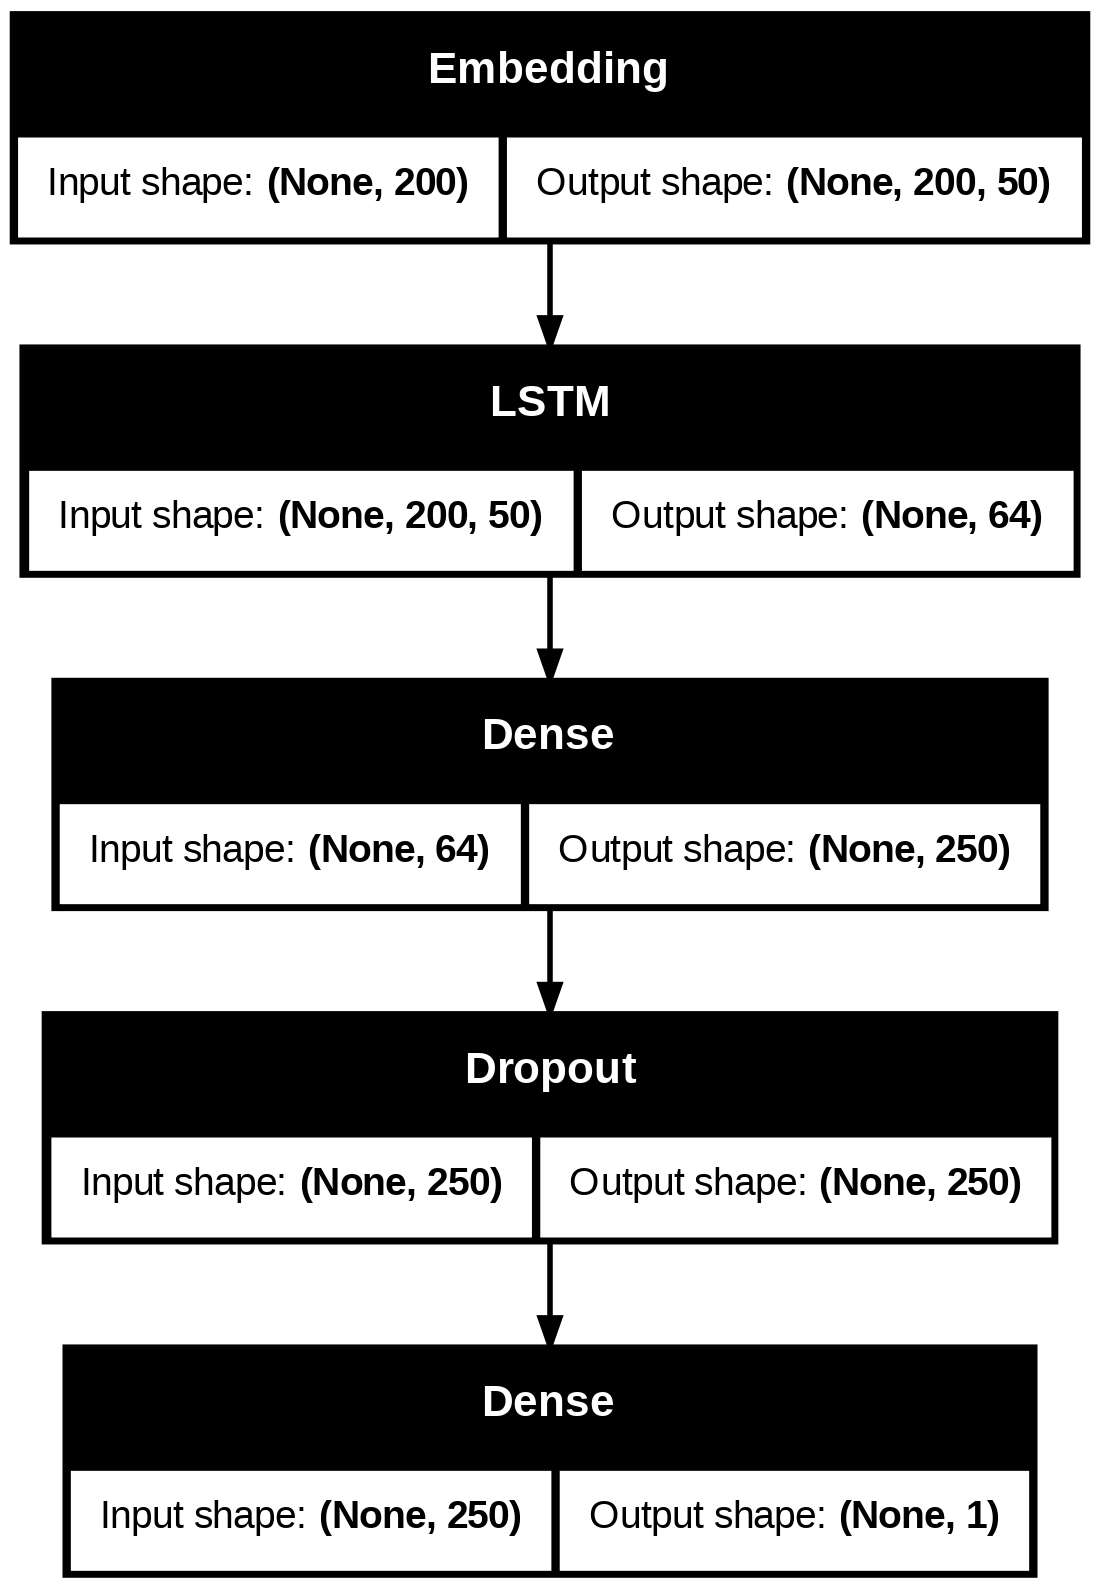

In [29]:
model_lstm.build(input_shape=(None,maxlen))

plotFile = plotModel(model_lstm, "imbdb_lstm")
IPython.display.Image(plotFile)

In [30]:
history_lstm=trainModel(model_lstm)

Epoch 1/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - acc: 0.7471 - loss: 0.4791 - val_acc: 0.8621 - val_loss: 0.3352
Epoch 2/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - acc: 0.9235 - loss: 0.2067 - val_acc: 0.8552 - val_loss: 0.3759
Epoch 3/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - acc: 0.9576 - loss: 0.1216 - val_acc: 0.8629 - val_loss: 0.3890


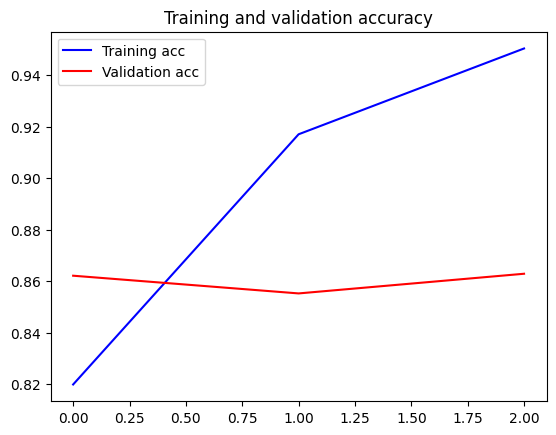

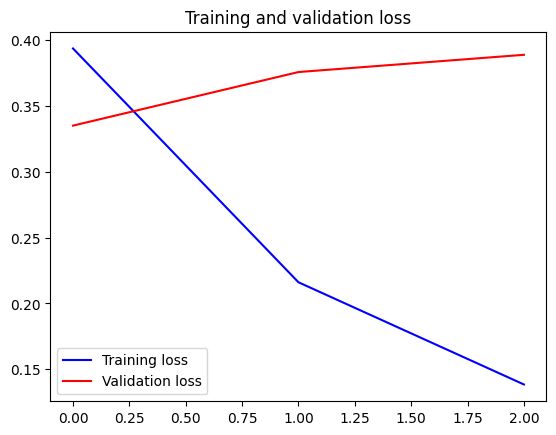

In [31]:
plot_training(history_lstm)

# Try a Transformer

Based on https://keras.io/examples/nlp/text_classification_with_transformer/

In [32]:
from keras.layers import MultiHeadAttention, LayerNormalization

class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [ Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [33]:
class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    # build: not needed.  Changed function name instead of just deleting definition
    def Xbuild(self, input_shape):
        super().build(input_shape)

    def call(self, x):
        maxlen = keras.ops.shape(x)[-1]
        # Use 'stop' instead of 'limit', 'step' instead of 'delta' for keras.ops.arange
        positions = keras.ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    # compute_output_shape: not needed. Changed function name instead of just deleting definition
    def Xcompute_output_shape(self, input_shape):
        # The output shape is (batch_size, maxlen, embed_dim)
        return (input_shape[0], self.maxlen, self.embed_dim)

In [34]:
vocab_size = max_features
embed_dim = embedding_dims

num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

model_transf = Sequential( [
                            TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim),
                            TransformerBlock(embed_dim, num_heads, ff_dim),
                            # Reduce sequence to finite length representation
                            GlobalMaxPooling1D(),
                            Dense(hidden_dims, activation='relu'),
                            Dropout(0.2),
                            # Classification
                            Dense(1, activation='sigmoid')
                    ])

## Can't show model summary or plot until it is "built" (after training)


In [35]:
model_transf.build(input_shape=(None,maxlen))

In [36]:
history_transf=trainModel(model_transf)

Epoch 1/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - acc: 0.6635 - loss: 0.5878 - val_acc: 0.8414 - val_loss: 0.3743
Epoch 2/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - acc: 0.9165 - loss: 0.2118 - val_acc: 0.8482 - val_loss: 0.3517
Epoch 3/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - acc: 0.9700 - loss: 0.0961 - val_acc: 0.8490 - val_loss: 0.4616
Epoch 4/8
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.9834 - loss: 0.0503 - val_acc: 0.8473 - val_loss: 0.5528


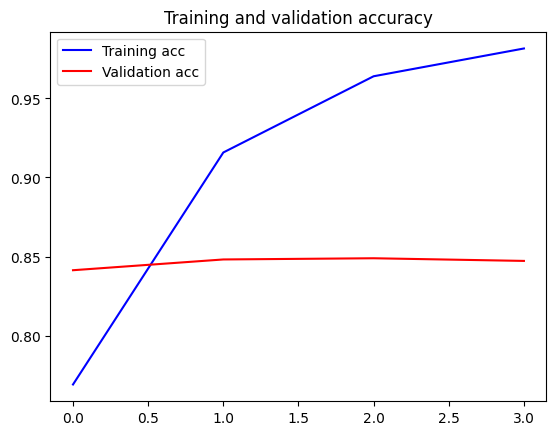

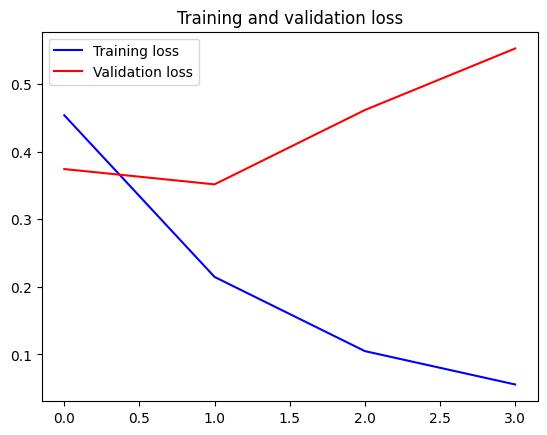

In [37]:
plot_training(history_transf)

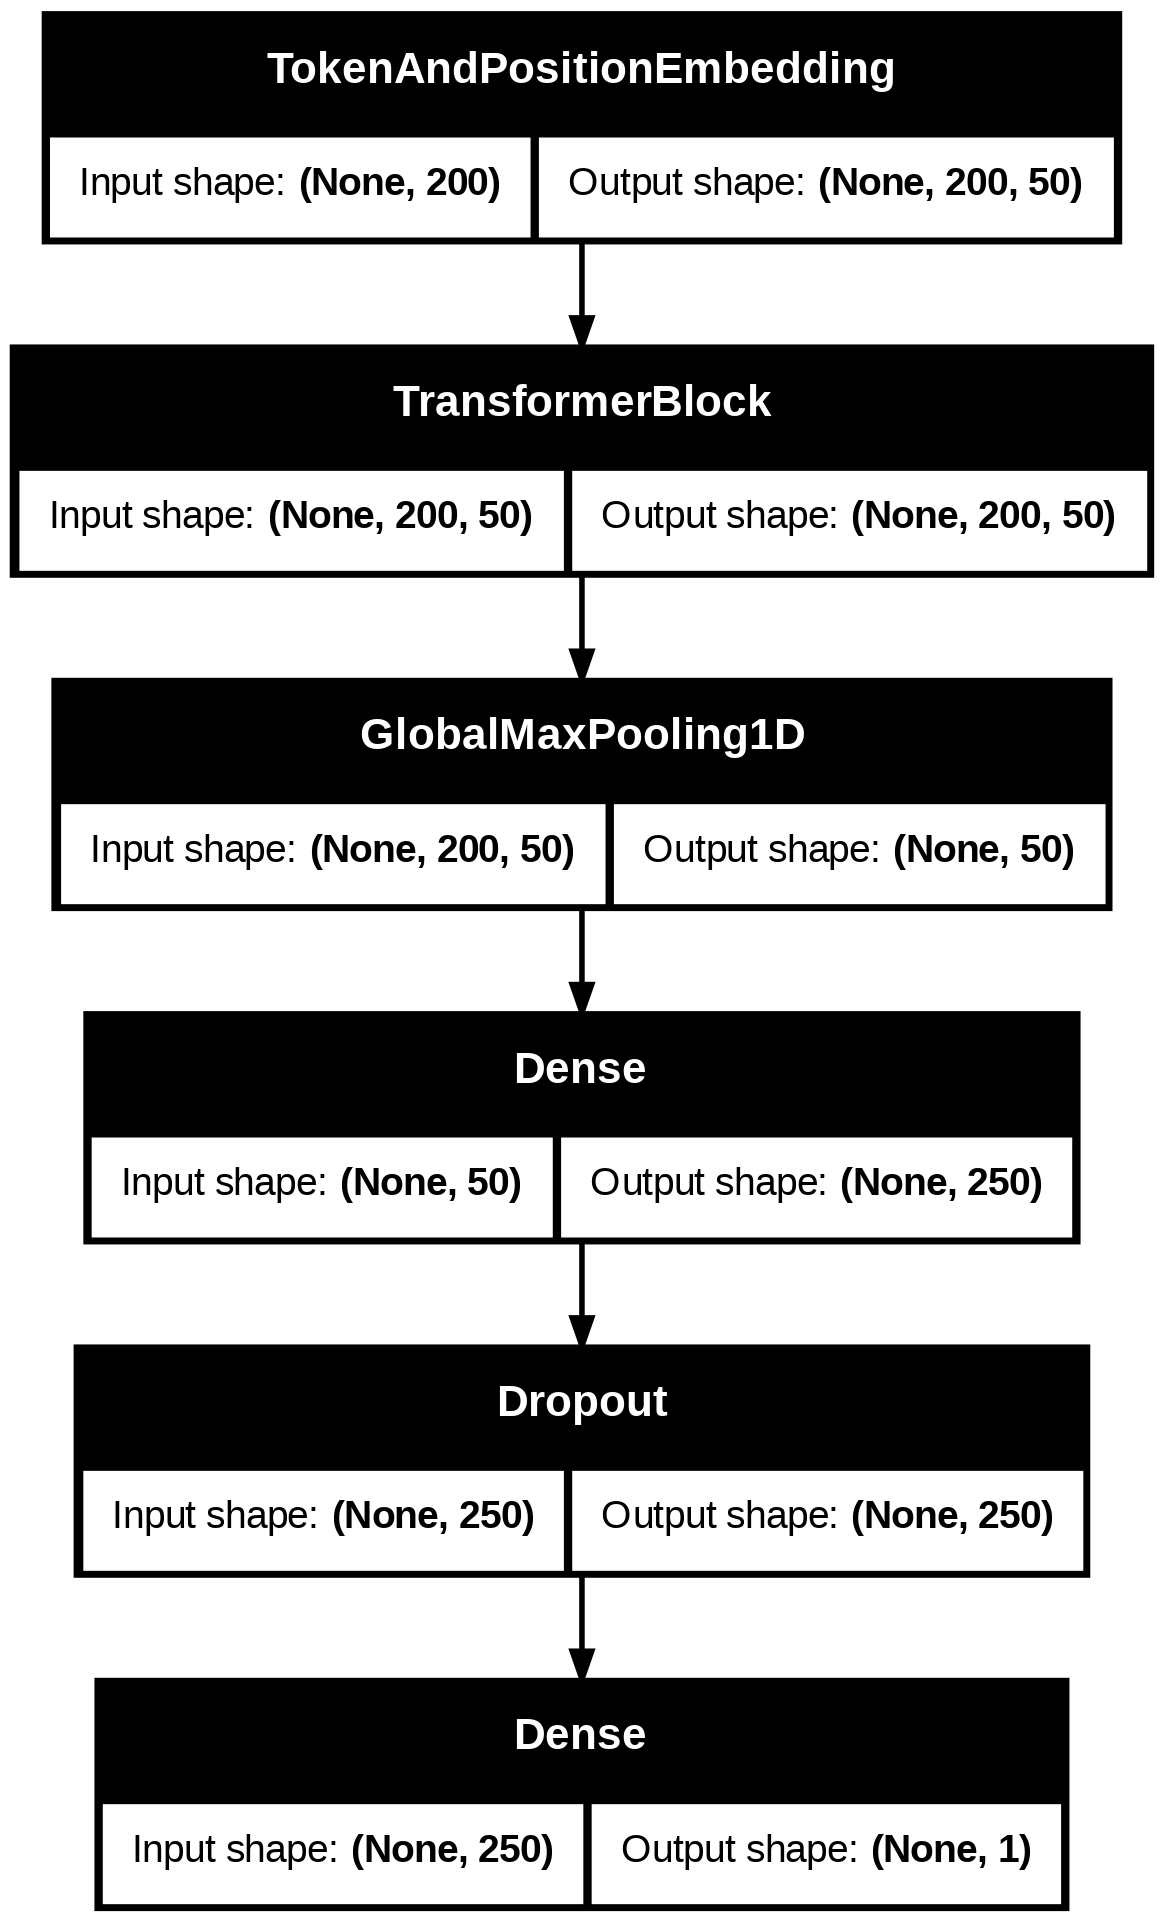

In [38]:
plot_model(model_transf, show_shapes=True)
